# Case Study: 마케팅 A/B 테스트 — 588K 유저 실데이터 분석

> **데이터**: [Kaggle Marketing A/B Testing](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing) (CC0 Public Domain, 588,101 users)
>
> **요약**: 광고(ad) vs 공익광고(PSA) 노출이 구매 전환에 미치는 효과를 분석합니다.
> 단순 전환율 비교를 넘어, **SRM 검증 → 세그먼트별 이질적 효과(HTE) 탐색 → 광고 노출량과 전환의 비선형 관계**를 발견합니다.

---

## 이 분석의 구조

1. **데이터 탐색** — 588K 유저의 행동 패턴 파악
2. **SRM 검증** — 96/4 split은 의도된 것인가?
3. **전체 효과 분석** — ExperimentOS 파이프라인 적용
4. **세그먼트 분석** — 요일/시간대/노출량별 이질적 효과
5. **핵심 발견** — 광고 포화 효과(Ad Saturation)
6. **비즈니스 권장** — 의사결정 및 후속 실험 제안

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats

from src.experimentos.healthcheck import run_health_check, detect_srm
from src.experimentos.analysis import calculate_primary

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (12, 5), 'font.size': 11})

df = pd.read_csv('marketing_AB.csv')
df = df.drop(columns=['Unnamed: 0'])
df.columns = ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']
df['converted'] = df['converted'].astype(int)

print(f'Dataset: {len(df):,} users')
print(f'Columns: {list(df.columns)}')
df.head()

Dataset: 588,101 users
Columns: ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']


,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


---

## 1. 탐색적 데이터 분석 (EDA)

In [2]:
# === 기본 통계 ===
print('=== Group Sizes ===')
group_counts = df['test_group'].value_counts()
for g, n in group_counts.items():
    conv = df[df['test_group'] == g]['converted'].sum()
    rate = conv / n
    print(f'  {g:>5s}: {n:>8,} users ({n/len(df):>5.1%}), '
          f'{conv:>6,} conversions ({rate:.2%})')

print(f'\n=== Overall ===')
print(f'  Total users:       {len(df):>10,}')
print(f'  Total conversions: {df["converted"].sum():>10,}')
print(f'  Overall CVR:       {df["converted"].mean():>10.2%}')
print(f'  Group ratio (ad/psa): {group_counts["ad"]/group_counts["psa"]:.1f}:1')

print(f'\n=== Ad Exposure ===')
print(df['total_ads'].describe().to_string())

=== Group Sizes ===
     ad:  564,577 users (96.0%), 14,423 conversions (2.55%)
    psa:   23,524 users ( 4.0%),    420 conversions (1.79%)

=== Overall ===
  Total users:          588,101
  Total conversions:     14,843
  Overall CVR:            2.52%
  Group ratio (ad/psa): 24.0:1

=== Ad Exposure ===
count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000


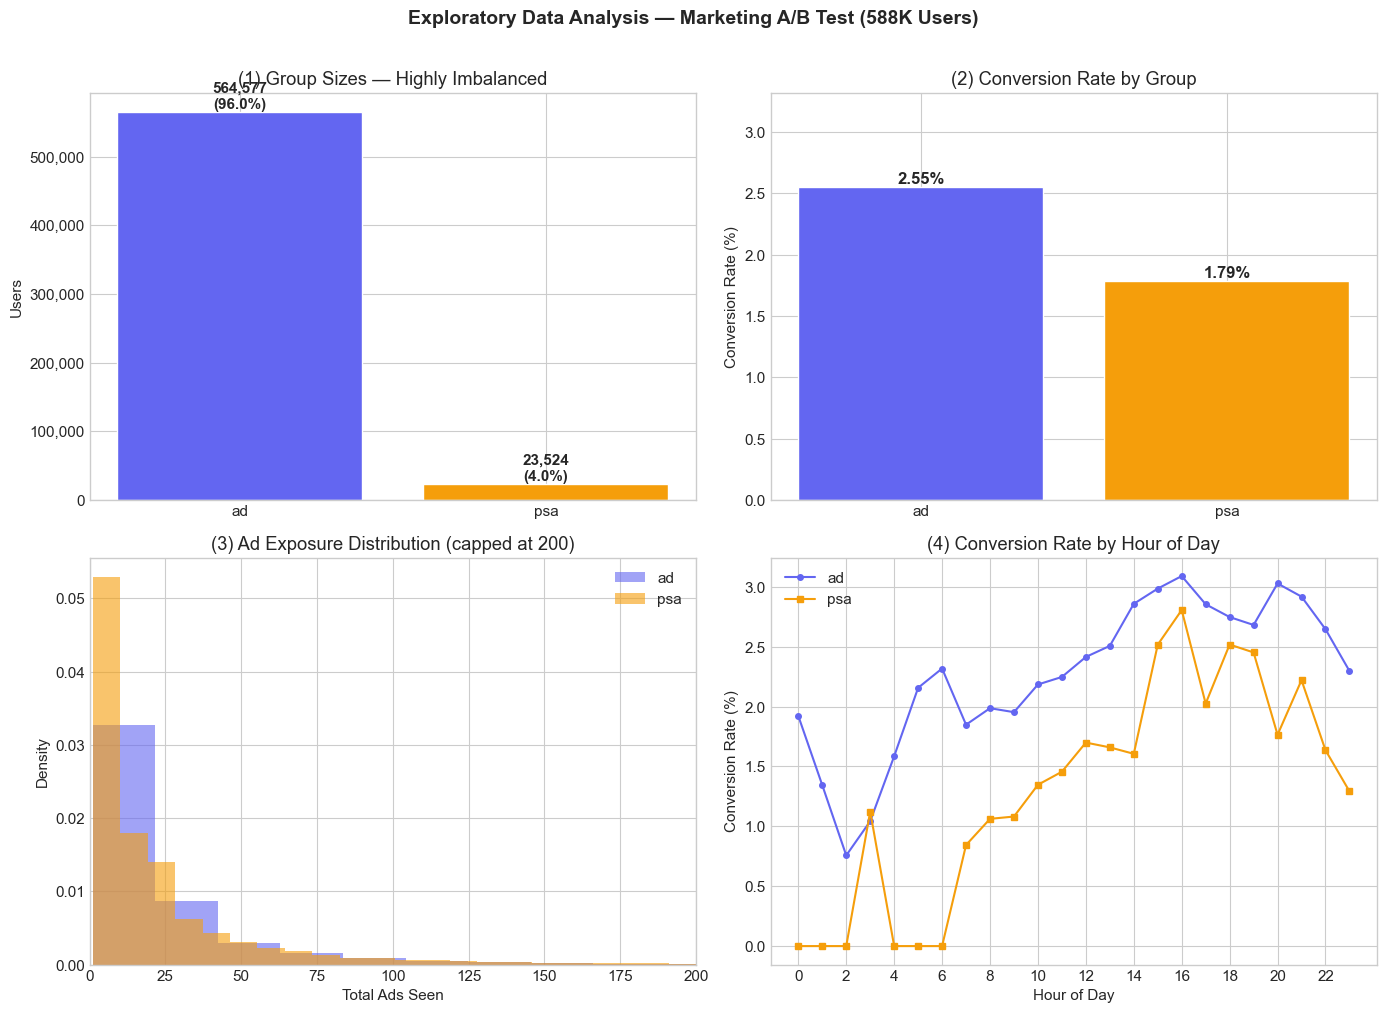

In [3]:
# === 4-panel EDA ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) Group size comparison
colors = {'ad': '#6366f1', 'psa': '#f59e0b'}
bars = axes[0, 0].bar(group_counts.index, group_counts.values,
                       color=[colors[g] for g in group_counts.index], edgecolor='white')
for bar, (g, n) in zip(bars, group_counts.items()):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
                    f'{n:,}\n({n/len(df):.1%})', ha='center', fontweight='bold')
axes[0, 0].set_title('(1) Group Sizes — Highly Imbalanced')
axes[0, 0].set_ylabel('Users')
axes[0, 0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# (2) Conversion rate by group
cvr_by_group = df.groupby('test_group')['converted'].mean() * 100
bar2 = axes[0, 1].bar(cvr_by_group.index, cvr_by_group.values,
                       color=[colors[g] for g in cvr_by_group.index], edgecolor='white')
for bar, (g, r) in zip(bar2, cvr_by_group.items()):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                    f'{r:.2f}%', ha='center', fontweight='bold', fontsize=12)
axes[0, 1].set_title('(2) Conversion Rate by Group')
axes[0, 1].set_ylabel('Conversion Rate (%)')
axes[0, 1].set_ylim(0, max(cvr_by_group) * 1.3)

# (3) Ad exposure distribution (log scale)
for g in ['ad', 'psa']:
    data = df[df['test_group'] == g]['total_ads']
    axes[1, 0].hist(data, bins=100, alpha=0.6, color=colors[g], label=g,
                    density=True, edgecolor='none')
axes[1, 0].set_xlim(0, 200)
axes[1, 0].set_title('(3) Ad Exposure Distribution (capped at 200)')
axes[1, 0].set_xlabel('Total Ads Seen')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()

# (4) Conversion rate by hour
cvr_hour = df.groupby(['most_ads_hour', 'test_group'])['converted'].mean() * 100
cvr_hour = cvr_hour.unstack()
cvr_hour['ad'].plot(ax=axes[1, 1], color=colors['ad'], marker='o', markersize=4, label='ad')
cvr_hour['psa'].plot(ax=axes[1, 1], color=colors['psa'], marker='s', markersize=4, label='psa')
axes[1, 1].set_title('(4) Conversion Rate by Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Conversion Rate (%)')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].legend()

plt.suptitle('Exploratory Data Analysis — Marketing A/B Test (588K Users)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('marketing_eda.png', dpi=150, bbox_inches='tight')
plt.show()

### EDA에서 발견한 것

1. **극단적 불균형**: ad 그룹이 96%, psa가 4%. 이것이 의도된 설계인지 확인 필요
2. **전환율 차이가 존재**: ad > psa로 보이지만, 노출량 차이가 교란 변수일 수 있음
3. **노출량 분포가 매우 오른쪽 꼬리**: 대부분 유저는 1-30회 노출, 일부는 2000+
4. **시간대별 패턴**: 시간대에 따라 전환율이 달라짐 — 세그먼트 분석 가치

---

## 2. SRM 검증 — "이 실험은 신뢰할 수 있는가?"

첫 번째 질문: 96/4 split은 **의도된 것인가, 아니면 무작위 배정 오류인가?**

In [4]:
# === SRM 검증: 다양한 기대 split으로 테스트 ===
n_ad = int(group_counts['ad'])
n_psa = int(group_counts['psa'])

print('=== SRM Test: 다양한 기대 분배 비율 ===')
print(f'Observed: ad={n_ad:,} ({n_ad/(n_ad+n_psa):.1%}), psa={n_psa:,} ({n_psa/(n_ad+n_psa):.1%})')
print()

test_splits = [
    ('50/50', [50.0, 50.0]),
    ('90/10', [90.0, 10.0]),
    ('95/5',  [95.0, 5.0]),
    ('96/4',  [96.0, 4.0]),
]

for label, split in test_splits:
    total = n_ad + n_psa
    expected_ad = total * split[0] / 100
    expected_psa = total * split[1] / 100
    chi2, p = stats.chisquare([n_ad, n_psa], [expected_ad, expected_psa])
    status = 'Blocked' if p < 1e-5 else ('Warning' if p < 0.001 else 'Healthy')
    emoji = {'Healthy': '✅', 'Warning': '⚠️', 'Blocked': '🚫'}[status]
    print(f'  Expected {label}: χ²={chi2:>12.1f}, p={p:.2e} → {emoji} {status}')

print(f'\n→ 50/50 가정에서는 SRM이 극심하게 감지됩니다.')
print(f'  하지만 96/4 가정에서는 Healthy입니다.')
print(f'  이 실험은 의도적으로 대부분의 유저에게 광고를 노출하는 설계입니다.')

=== SRM Test: 다양한 기대 분배 비율 ===
Observed: ad=564,577 (96.0%), psa=23,524 (4.0%)

  Expected 50/50: χ²=    497768.8, p=0.00e+00 → 🚫 Blocked
  Expected 90/10: χ²=     23524.1, p=0.00e+00 → 🚫 Blocked
  Expected 95/5: χ²=      1238.1, p=3.16e-271 → 🚫 Blocked
  Expected 96/4: χ²=         0.0, p=1.00e+00 → ✅ Healthy

→ 50/50 가정에서는 SRM이 극심하게 감지됩니다.
  하지만 96/4 가정에서는 Healthy입니다.
  이 실험은 의도적으로 대부분의 유저에게 광고를 노출하는 설계입니다.


### SRM 분석 교훈

**기대 분배를 모르면 SRM은 의미 없습니다.** 이 실험은 의도적으로 96/4로 설계되었습니다.

실무에서 SRM 검증을 위해 반드시 확인해야 할 것:
1. 실험 설계 문서의 **기대 분배 비율** (50/50이 기본이지만 항상 그런 것은 아님)
2. 불균형이 **의도적**인지 (risk mitigation, 점진적 rollout 등)
3. 의도적 불균형에서도 **관측값이 기대값과 일치**하는지

---

## 3. 전체 효과 분석

In [5]:
# === ExperimentOS로 전체 분석 ===
ad_users = int(group_counts['ad'])
ad_conv = int(df[df['test_group'] == 'ad']['converted'].sum())
psa_users = int(group_counts['psa'])
psa_conv = int(df[df['test_group'] == 'psa']['converted'].sum())

experiment_df = pd.DataFrame([
    {'variant': 'control', 'users': psa_users, 'conversions': psa_conv},
    {'variant': 'treatment', 'users': ad_users, 'conversions': ad_conv},
])

print('Input (ExperimentOS format):')
display(experiment_df)

# Health check with correct expected split (4/96 for control/treatment)
srm_result = detect_srm(
    {'control': psa_users, 'treatment': ad_users},
    expected_split=[4.0, 96.0]
)
print(f'\nSRM (expected 4/96): {srm_result["status"]} (p={srm_result["p_value"]:.4f})')

# Primary analysis
primary = calculate_primary(experiment_df.copy())

rate_c = psa_conv / psa_users
rate_t = ad_conv / ad_users
abs_lift = rate_t - rate_c
rel_lift = (rate_t / rate_c - 1)

ci_lo, ci_hi = primary["ci_95"]

print(f'\n=== Primary Analysis ===')
print(f'  Control (PSA):   {rate_c:.3%} ({psa_conv:,}/{psa_users:,})')
print(f'  Treatment (Ad):  {rate_t:.3%} ({ad_conv:,}/{ad_users:,})')
print(f'  Absolute Lift:   {abs_lift:+.3%}p')
print(f'  Relative Lift:   {rel_lift:+.1%}')
print(f'  P-value:         {primary["p_value"]:.2e}')
print(f'  Significant:     {"Yes ✅" if primary["p_value"] < 0.05 else "No"}')
print(f'  95% CI:          [{ci_lo:+.4f}, {ci_hi:+.4f}]')

Input (ExperimentOS format):


,variant,users,conversions
0,control,23524,420
1,treatment,564577,14423



SRM (expected 4/96): Healthy (p=0.9998)

=== Primary Analysis ===
  Control (PSA):   1.785% (420/23,524)
  Treatment (Ad):  2.555% (14,423/564,577)
  Absolute Lift:   +0.769%p
  Relative Lift:   +43.1%
  P-value:         1.71e-13
  Significant:     Yes ✅
  95% CI:          [+0.0059, +0.0094]


전체 분석 결과: 광고 노출은 구매 전환율을 유의하게 높입니다.

하지만 **"모든 유저에게 동일하게 효과적인가?"**라는 질문이 남습니다.

---

## 4. 세그먼트 분석 — 이질적 효과(HTE) 탐색

전체 평균은 종종 중요한 패턴을 숨깁니다. **Simpson's Paradox**를 경계하며 세그먼트별로 분석합니다.

In [6]:
# === 세그먼트 분석 함수 ===
def segment_analysis(df, segment_col, segment_label):
    """Run conversion analysis per segment."""
    rows = []
    for seg_val in sorted(df[segment_col].unique()):
        seg_df = df[df[segment_col] == seg_val]
        for group in ['psa', 'ad']:
            g_df = seg_df[seg_df['test_group'] == group]
            rows.append({
                'segment': seg_val,
                'group': group,
                'users': len(g_df),
                'conversions': int(g_df['converted'].sum()),
                'cvr': g_df['converted'].mean(),
            })
    seg_df = pd.DataFrame(rows)
    
    # Calculate lift per segment
    results = []
    for seg_val in sorted(df[segment_col].unique()):
        ad_row = seg_df[(seg_df['segment'] == seg_val) & (seg_df['group'] == 'ad')].iloc[0]
        psa_row = seg_df[(seg_df['segment'] == seg_val) & (seg_df['group'] == 'psa')].iloc[0]
        
        lift = ad_row['cvr'] - psa_row['cvr']
        # Z-test
        n1, c1 = ad_row['users'], ad_row['conversions']
        n2, c2 = psa_row['users'], psa_row['conversions']
        p_pool = (c1 + c2) / (n1 + n2) if (n1 + n2) > 0 else 0
        se = np.sqrt(p_pool * (1-p_pool) * (1/max(n1,1) + 1/max(n2,1))) if 0 < p_pool < 1 else 1
        z = lift / se if se > 0 else 0
        p_val = 2 * (1 - stats.norm.cdf(abs(z)))
        
        results.append({
            'segment': seg_val,
            'ad_cvr': ad_row['cvr'],
            'psa_cvr': psa_row['cvr'],
            'lift': lift,
            'rel_lift': (ad_row['cvr'] / psa_row['cvr'] - 1) if psa_row['cvr'] > 0 else 0,
            'p_value': p_val,
            'significant': p_val < 0.05,
            'ad_n': n1,
            'psa_n': n2,
        })
    
    return pd.DataFrame(results)

print('Segment analysis function ready.')

Segment analysis function ready.


In [7]:
# === 요일별 세그먼트 분석 ===
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_results = segment_analysis(df, 'most_ads_day', 'Day of Week')
day_results['segment'] = pd.Categorical(day_results['segment'], categories=day_order, ordered=True)
day_results = day_results.sort_values('segment')

print('=== Conversion Rate by Day of Week ===')
print(f'{"Day":>12s}  {"Ad CVR":>8s}  {"PSA CVR":>8s}  {"Lift":>8s}  {"Rel Lift":>10s}  {"p-value":>10s}  {"Sig":>5s}')
for _, row in day_results.iterrows():
    sig = '✅' if row['significant'] else ''
    print(f'{row["segment"]:>12s}  {row["ad_cvr"]:>8.2%}  {row["psa_cvr"]:>8.2%}  '
          f'{row["lift"]:>+8.3%}p  {row["rel_lift"]:>+10.1%}  {row["p_value"]:>10.4f}  {sig:>5s}')

=== Conversion Rate by Day of Week ===
         Day    Ad CVR   PSA CVR      Lift    Rel Lift     p-value    Sig
      Monday     3.32%     2.26%   +1.068%p      +47.4%      0.0005      ✅
     Tuesday     3.04%     1.44%   +1.599%p     +110.7%      0.0000      ✅
   Wednesday     2.54%     1.58%   +0.960%p      +60.9%      0.0004      ✅
    Thursday     2.16%     2.02%   +0.141%p       +7.0%      0.5548       
      Friday     2.25%     1.63%   +0.616%p      +37.8%      0.0116      ✅
    Saturday     2.13%     1.40%   +0.731%p      +52.2%      0.0075      ✅
      Sunday     2.46%     2.06%   +0.402%p      +19.5%      0.1572       


In [8]:
# === 시간대별 세그먼트 분석 ===
# 시간대를 4개 구간으로 그룹핑
df['hour_bucket'] = pd.cut(df['most_ads_hour'],
                           bins=[-1, 6, 12, 18, 24],
                           labels=['Night (0-6)', 'Morning (7-12)', 'Afternoon (13-18)', 'Evening (19-24)'])

hour_results = segment_analysis(df, 'hour_bucket', 'Time of Day')

print('=== Conversion Rate by Time of Day ===')
print(f'{"Time":>20s}  {"Ad CVR":>8s}  {"PSA CVR":>8s}  {"Lift":>8s}  {"Rel Lift":>10s}  {"Sig":>5s}')
for _, row in hour_results.iterrows():
    sig = '✅' if row['significant'] else ''
    print(f'{str(row["segment"]):>20s}  {row["ad_cvr"]:>8.2%}  {row["psa_cvr"]:>8.2%}  '
          f'{row["lift"]:>+8.3%}p  {row["rel_lift"]:>+10.1%}  {sig:>5s}')

=== Conversion Rate by Time of Day ===
                Time    Ad CVR   PSA CVR      Lift    Rel Lift    Sig
   Afternoon (13-18)     2.83%     2.14%   +0.690%p      +32.2%      ✅
     Evening (19-24)     2.74%     1.95%   +0.795%p      +40.8%      ✅
      Morning (7-12)     2.19%     1.39%   +0.800%p      +57.6%      ✅
         Night (0-6)     1.44%     0.12%   +1.315%p    +1075.4%      ✅


In [9]:
# === 핵심: 광고 노출량별 전환율 분석 ===
bins = [0, 5, 10, 20, 50, 100, 200, 500, float('inf')]
labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '101-200', '201-500', '500+']
df['ads_bucket'] = pd.cut(df['total_ads'], bins=bins, labels=labels, right=True)

ads_results = segment_analysis(df, 'ads_bucket', 'Ad Exposure')
# Preserve correct exposure order (not lexicographic)
ads_results['segment'] = pd.Categorical(ads_results['segment'], categories=labels, ordered=True)
ads_results = ads_results.sort_values('segment').reset_index(drop=True)

print('=== Conversion Rate by Ad Exposure Level ===')
print(f'{"Ads Seen":>12s}  {"Ad Users":>10s}  {"Ad CVR":>8s}  {"PSA CVR":>8s}  {"Lift":>8s}  {"Rel":>8s}  {"Sig":>5s}')
for _, row in ads_results.iterrows():
    sig = '✅' if row['significant'] else ''
    print(f'{str(row["segment"]):>12s}  {row["ad_n"]:>10,}  {row["ad_cvr"]:>8.2%}  {row["psa_cvr"]:>8.2%}  '
          f'{row["lift"]:>+8.3%}p  {row["rel_lift"]:>+8.1%}  {sig:>5s}')

=== Conversion Rate by Ad Exposure Level ===
    Ads Seen    Ad Users    Ad CVR   PSA CVR      Lift       Rel    Sig
         1-5     169,962     0.25%     0.28%   -0.029%p    -10.2%       
        6-10      79,537     0.49%     0.67%   -0.188%p    -27.9%       
       11-20     123,334     0.84%     0.82%   +0.021%p     +2.5%       
       21-50     125,541     2.92%     2.18%   +0.738%p    +33.9%      ✅
      51-100      44,149    11.63%     5.77%   +5.857%p   +101.4%      ✅
     101-200      16,360    17.68%    10.64%   +7.039%p    +66.2%      ✅
     201-500       5,128    15.37%    15.90%   -0.533%p     -3.4%       
        500+         566    17.49%    10.53%   +6.965%p    +66.2%       


C:\Users\PC\AppData\Local\Temp\ipykernel_65068\2799885702.py:44: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_65068\2799885702.py:45: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('marketing_segment_analysis.png', dpi=150, bbox_inches='tight')


C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


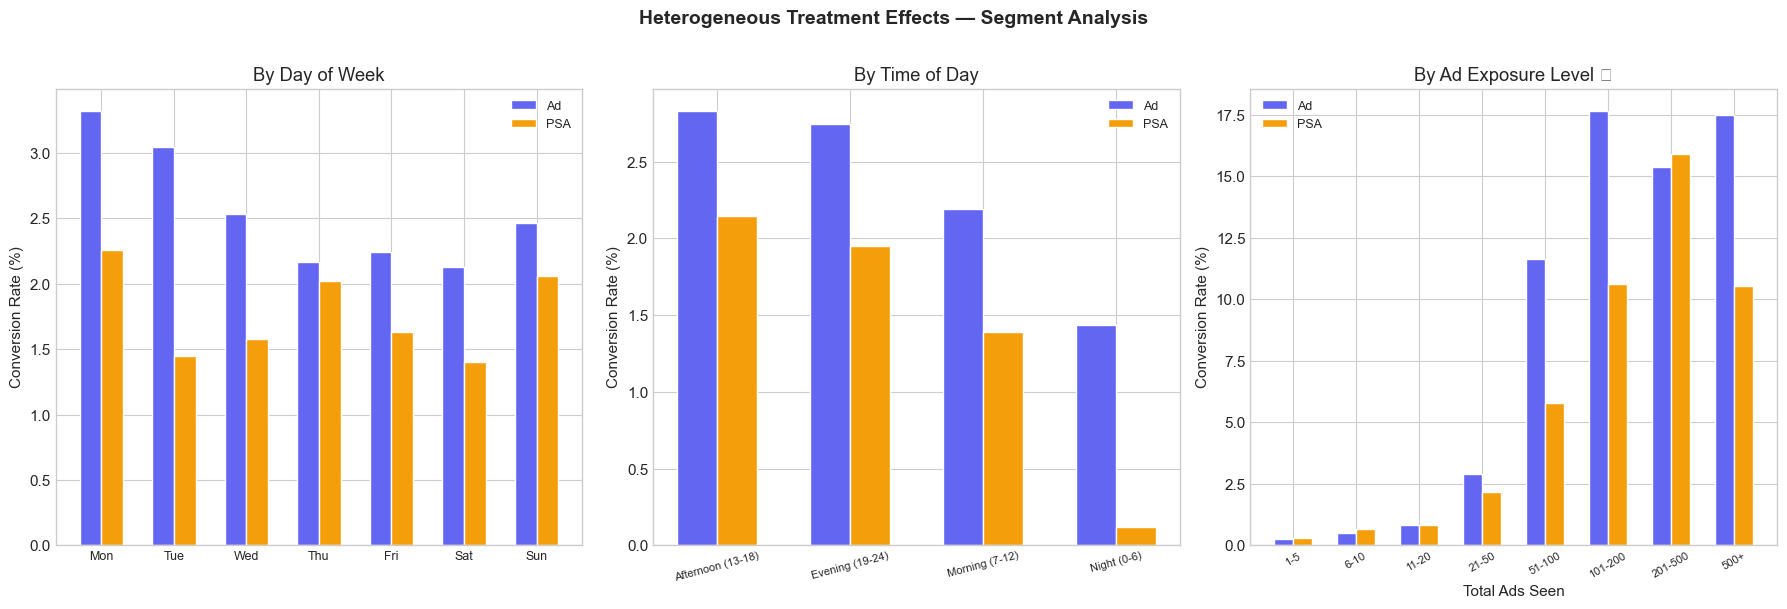

In [10]:
# === 핵심 시각화: 세그먼트별 효과 비교 ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (1) Day of Week
x_days = range(len(day_results))
w = 0.3
axes[0].bar([i - w/2 for i in x_days], day_results['ad_cvr'] * 100, w,
            color='#6366f1', label='Ad', edgecolor='white')
axes[0].bar([i + w/2 for i in x_days], day_results['psa_cvr'] * 100, w,
            color='#f59e0b', label='PSA', edgecolor='white')
axes[0].set_xticks(list(x_days))
axes[0].set_xticklabels([d[:3] for d in day_order], fontsize=9)
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('By Day of Week')
axes[0].legend(fontsize=9)

# (2) Time of Day
x_hours = range(len(hour_results))
axes[1].bar([i - w/2 for i in x_hours], hour_results['ad_cvr'] * 100, w,
            color='#6366f1', label='Ad', edgecolor='white')
axes[1].bar([i + w/2 for i in x_hours], hour_results['psa_cvr'] * 100, w,
            color='#f59e0b', label='PSA', edgecolor='white')
axes[1].set_xticks(list(x_hours))
axes[1].set_xticklabels([str(s) for s in hour_results['segment']], fontsize=8, rotation=15)
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].set_title('By Time of Day')
axes[1].legend(fontsize=9)

# (3) Ad Exposure — the key finding
x_ads = range(len(ads_results))
axes[2].bar([i - w/2 for i in x_ads], ads_results['ad_cvr'] * 100, w,
            color='#6366f1', label='Ad', edgecolor='white')
axes[2].bar([i + w/2 for i in x_ads], ads_results['psa_cvr'] * 100, w,
            color='#f59e0b', label='PSA', edgecolor='white')
axes[2].set_xticks(list(x_ads))
axes[2].set_xticklabels([str(s) for s in ads_results['segment']], fontsize=8, rotation=30)
axes[2].set_ylabel('Conversion Rate (%)')
axes[2].set_xlabel('Total Ads Seen')
axes[2].set_title('By Ad Exposure Level ★')
axes[2].legend(fontsize=9)

plt.suptitle('Heterogeneous Treatment Effects — Segment Analysis',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('marketing_segment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. 핵심 발견: 광고 노출량과 전환율의 비선형 관계

세그먼트 분석에서 가장 흥미로운 발견은 **광고 노출량(total_ads)**에 따른 전환율 패턴입니다.

C:\Users\PC\AppData\Local\Temp\ipykernel_65068\2547605094.py:75: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_65068\2547605094.py:76: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.savefig('marketing_dose_response.png', dpi=150, bbox_inches='tight')


C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


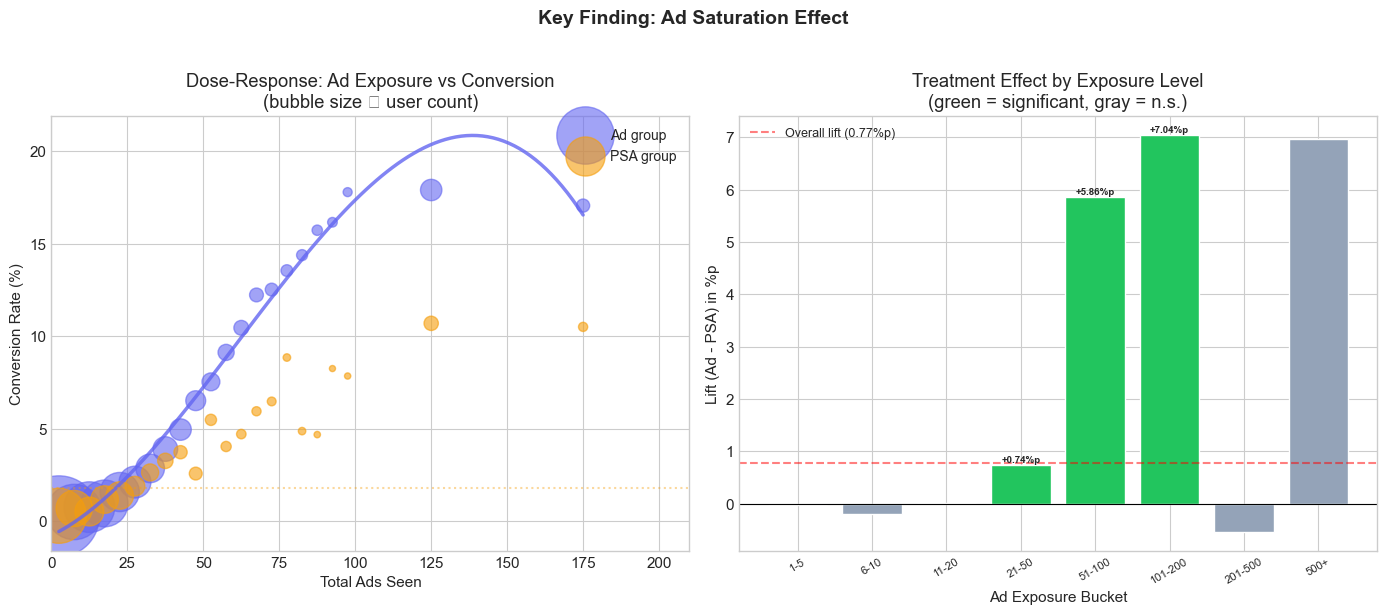

In [11]:
# === 광고 노출량 vs 전환율: 비선형 관계 ===
ad_df = df[df['test_group'] == 'ad'].copy()
psa_df = df[df['test_group'] == 'psa'].copy()

# 세밀한 구간 (0 포함을 위해 -0.1부터)
fine_bins = [-0.1] + list(range(5, 105, 5)) + [150, 200, 300, 500, 10000]
ad_df['ads_fine'] = pd.cut(ad_df['total_ads'], bins=fine_bins)
psa_df['ads_fine'] = pd.cut(psa_df['total_ads'], bins=fine_bins)

ad_curve = ad_df.groupby('ads_fine', observed=True).agg(
    users=('converted', 'count'),
    conversions=('converted', 'sum')
).reset_index()
ad_curve['cvr'] = ad_curve['conversions'] / ad_curve['users']
# Categorical-safe midpoint computation
ad_curve['midpoint'] = [(x.left + x.right) / 2 for x in ad_curve['ads_fine']]
ad_curve['midpoint'] = ad_curve['midpoint'].astype(float)
ad_curve = ad_curve[ad_curve['users'] >= 100]

psa_curve = psa_df.groupby('ads_fine', observed=True).agg(
    users=('converted', 'count'),
    conversions=('converted', 'sum')
).reset_index()
psa_curve['cvr'] = psa_curve['conversions'] / psa_curve['users']
psa_curve['midpoint'] = [(x.left + x.right) / 2 for x in psa_curve['ads_fine']]
psa_curve['midpoint'] = psa_curve['midpoint'].astype(float)
psa_curve = psa_curve[psa_curve['users'] >= 30]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Dose-response curve
axes[0].scatter(ad_curve['midpoint'].values, ad_curve['cvr'].values * 100,
                s=ad_curve['users'].values / 50, alpha=0.6, color='#6366f1', label='Ad group')
axes[0].scatter(psa_curve['midpoint'].values, psa_curve['cvr'].values * 100,
                s=psa_curve['users'].values / 5, alpha=0.6, color='#f59e0b', label='PSA group')

# Smoothed trend for ad group
from numpy.polynomial.polynomial import polyfit
x_smooth = ad_curve.loc[ad_curve['midpoint'] <= 200, 'midpoint'].values.astype(float)
y_smooth = ad_curve.loc[ad_curve['midpoint'] <= 200, 'cvr'].values.astype(float) * 100
if len(x_smooth) > 3:
    coeffs = polyfit(x_smooth, y_smooth, 3)
    x_line = np.linspace(x_smooth.min(), x_smooth.max(), 100)
    y_line = sum(c * x_line**i for i, c in enumerate(coeffs))
    axes[0].plot(x_line, y_line, '-', color='#6366f1', linewidth=2.5, alpha=0.8)

axes[0].set_xlabel('Total Ads Seen')
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('Dose-Response: Ad Exposure vs Conversion\n(bubble size ∝ user count)')
axes[0].set_xlim(0, 210)
axes[0].legend(fontsize=10)
axes[0].axhline(y=rate_c * 100, color='#f59e0b', linestyle=':', alpha=0.4, label='PSA baseline')

# Right: Lift by exposure
axes[1].bar(range(len(ads_results)), ads_results['lift'].values * 100,
            color=['#22c55e' if s else '#94a3b8' for s in ads_results['significant']],
            edgecolor='white')
axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].axhline(y=abs_lift * 100, color='red', linestyle='--', alpha=0.5,
                label=f'Overall lift ({abs_lift*100:.2f}%p)')
axes[1].set_xticks(range(len(ads_results)))
axes[1].set_xticklabels([str(s) for s in ads_results['segment']], fontsize=8, rotation=30)
axes[1].set_xlabel('Ad Exposure Bucket')
axes[1].set_ylabel('Lift (Ad - PSA) in %p')
axes[1].set_title('Treatment Effect by Exposure Level\n(green = significant, gray = n.s.)')
axes[1].legend(fontsize=9)

for i, (_, row) in enumerate(ads_results.iterrows()):
    if row['significant']:
        axes[1].text(i, row['lift'] * 100 + 0.05, f'{row["lift"]*100:+.2f}%p',
                     ha='center', fontsize=7, fontweight='bold')

plt.suptitle('Key Finding: Ad Saturation Effect',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('marketing_dose_response.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# === 정량 요약: 노출량 구간별 효과 크기 ===
print('=== Ad Exposure Effect Summary ===')
print(f'\nOverall treatment effect: {abs_lift*100:+.3f}%p ({rel_lift:+.1%})')
print(f'\nBy exposure level:')

for _, row in ads_results.iterrows():
    sig_marker = '***' if row['p_value'] < 0.001 else ('**' if row['p_value'] < 0.01 else ('*' if row['p_value'] < 0.05 else 'n.s.'))
    direction = '↑' if row['lift'] > 0 else ('↓' if row['lift'] < 0 else '→')
    print(f'  {str(row["segment"]):>12s}: {direction} {row["lift"]*100:+.3f}%p '
          f'(ad={row["ad_cvr"]:.2%}, psa={row["psa_cvr"]:.2%}) [{sig_marker}]')

# Overall insight
sig_segments = ads_results[ads_results['significant']]
not_sig = ads_results[~ads_results['significant']]
print(f'\n→ 유의한 효과: {len(sig_segments)}/{len(ads_results)} 세그먼트')
if len(not_sig) > 0:
    print(f'  비유의 세그먼트: {list(not_sig["segment"].values)}')
print(f'\n→ 핵심: 전체 평균은 유의하지만, 노출량에 따라 효과 크기가 달라집니다.')

=== Ad Exposure Effect Summary ===

Overall treatment effect: +0.769%p (+43.1%)

By exposure level:
           1-5: ↓ -0.029%p (ad=0.25%, psa=0.28%) [n.s.]
          6-10: ↓ -0.188%p (ad=0.49%, psa=0.67%) [n.s.]
         11-20: ↑ +0.021%p (ad=0.84%, psa=0.82%) [n.s.]
         21-50: ↑ +0.738%p (ad=2.92%, psa=2.18%) [**]
        51-100: ↑ +5.857%p (ad=11.63%, psa=5.77%) [***]
       101-200: ↑ +7.039%p (ad=17.68%, psa=10.64%) [***]
       201-500: ↓ -0.533%p (ad=15.37%, psa=15.90%) [n.s.]
          500+: ↑ +6.965%p (ad=17.49%, psa=10.53%) [n.s.]

→ 유의한 효과: 3/8 세그먼트
  비유의 세그먼트: ['1-5', '6-10', '11-20', '201-500', '500+']

→ 핵심: 전체 평균은 유의하지만, 노출량에 따라 효과 크기가 달라집니다.


---

## 5.5 비즈니스 임팩트 추정 — "그래서 돈으로 얼마?"

통계적 유의성만으로는 의사결정이 되지 않습니다. PM이 듣고 싶은 것은 **"매출이 얼마나 바뀌나요?"**입니다.

In [13]:
# === 비즈니스 임팩트 추정 ===
# 가정: 전환당 매출(AOV) = $50 (e-commerce 평균)
AOV = 50  # Average Order Value (USD)

print('=' * 65)
print('  BUSINESS IMPACT ESTIMATION')
print('  Assumption: Average Order Value (AOV) = ${:,.0f}'.format(AOV))
print('=' * 65)

# 1. 전체 증분 효과
incremental_conv = ad_users * abs_lift
incremental_rev = incremental_conv * AOV

print(f'\n[1] Overall Incremental Impact')
print(f'    Ad users:                {ad_users:>12,}')
print(f'    Lift (ad - psa):         {abs_lift:>12.4f} ({abs_lift*100:+.3f}%p)')
print(f'    Incremental conversions: {incremental_conv:>12,.0f}')
print(f'    Incremental revenue:     ${incremental_rev:>12,.0f}')

# 2. 세그먼트별 증분 기여
print(f'\n[2] Incremental Revenue by Exposure Segment')
print(f'    {"Segment":>12s}  {"Ad Users":>10s}  {"Lift":>8s}  {"Incr Conv":>10s}  {"Incr Rev":>12s}  {"Share":>6s}')

total_positive_incr = 0
segment_impacts = []
for _, row in ads_results.iterrows():
    incr = row['ad_n'] * row['lift']
    rev = incr * AOV
    segment_impacts.append({
        'segment': str(row['segment']),
        'ad_n': row['ad_n'],
        'lift': row['lift'],
        'incr_conv': incr,
        'incr_rev': rev
    })
    if incr > 0:
        total_positive_incr += incr

for s in segment_impacts:
    share = (s['incr_conv'] / total_positive_incr * 100) if s['incr_conv'] > 0 and total_positive_incr > 0 else 0
    marker = ' ***' if s['incr_conv'] > 500 else ''
    print(f'    {s["segment"]:>12s}  {s["ad_n"]:>10,}  {s["lift"]:>+8.3%}p  {s["incr_conv"]:>10,.0f}  ${s["incr_rev"]:>11,.0f}  {share:>5.1f}%{marker}')

print(f'\n    {"TOTAL (positive)":>12s}  {"":>10s}  {"":>8s}  {total_positive_incr:>10,.0f}  ${total_positive_incr * AOV:>11,.0f}')

# 3. Frequency Cap 시나리오 분석
print(f'\n[3] Frequency Cap Scenario Analysis')
print(f'    현재 저노출(1-20회) 유저 수:')
low_exp = ads_results[ads_results['segment'].isin(['1-5', '6-10', '11-20'])]
low_exp_users = int(low_exp['ad_n'].sum())
mid_lift = float(ads_results[ads_results['segment'] == '21-50']['lift'].values[0])

print(f'      {low_exp_users:,} users (현재 효과: ~0%p)')
print(f'\n    시나리오: 이 유저들의 노출을 21-50회 수준으로 올리면?')
print(f'      기대 Lift: {mid_lift:+.3%}p (21-50 구간 관측값)')
print(f'      추가 전환: {low_exp_users * mid_lift:,.0f}')
print(f'      추가 매출: ${low_exp_users * mid_lift * AOV:,.0f}')
print(f'\n    ⚠️  주의: 이 추정은 "노출량 증가 → 전환율 증가"의 인과를 가정합니다.')
print(f'       자기선택 편향(구매 의향 높은 유저가 광고를 더 많이 봄)을')
print(f'       통제하지 않았으므로, 실제 효과는 이보다 작을 수 있습니다.')
print(f'       → Frequency Cap 실험으로 검증 필요')

  BUSINESS IMPACT ESTIMATION
  Assumption: Average Order Value (AOV) = $50

[1] Overall Incremental Impact
    Ad users:                     564,577
    Lift (ad - psa):               0.0077 (+0.769%p)
    Incremental conversions:        4,343
    Incremental revenue:     $     217,149

[2] Incremental Revenue by Exposure Segment
         Segment    Ad Users      Lift   Incr Conv      Incr Rev   Share
             1-5     169,962   -0.029%p         -49  $     -2,433    0.0%
            6-10      79,537   -0.188%p        -150  $     -7,484    0.0%
           11-20     123,334   +0.021%p          26  $      1,278    0.5%
           21-50     125,541   +0.738%p         926  $     46,308   19.6% ***
          51-100      44,149   +5.857%p       2,586  $    129,283   54.7% ***
         101-200      16,360   +7.039%p       1,152  $     57,579   24.4% ***
         201-500       5,128   -0.533%p         -27  $     -1,367    0.0%
            500+         566   +6.965%p          39  $      1,971

---

## 6. 비즈니스 인사이트 & 권장 사항

### 발견된 핵심 패턴

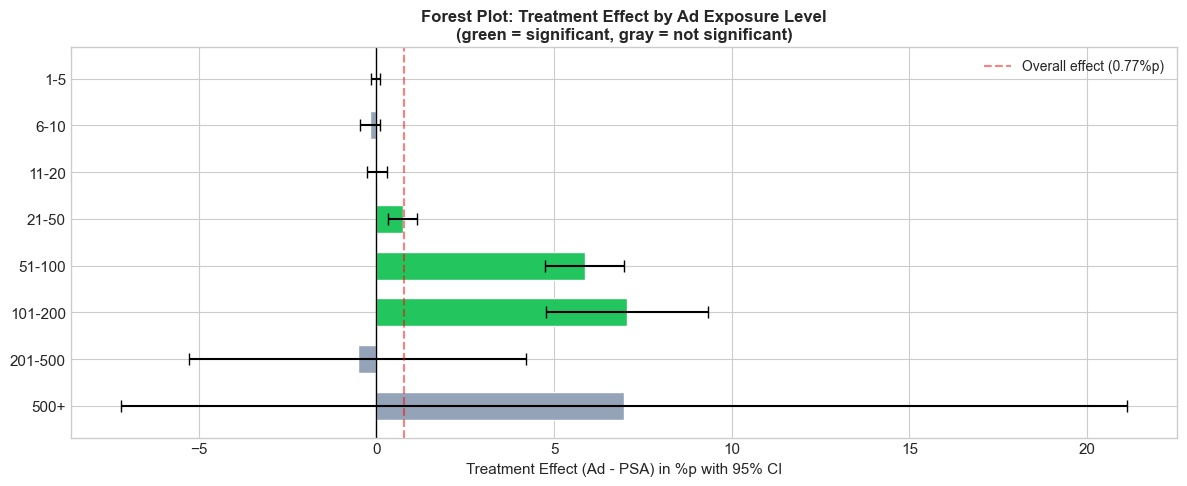

In [14]:
# === 최종 요약 시각화 ===
fig, ax = plt.subplots(figsize=(12, 5))

# Effect size by exposure with CI
segments = [str(s) for s in ads_results['segment']]
lifts = ads_results['lift'].values * 100

# Calculate confidence intervals
ci_errors = []
for _, row in ads_results.iterrows():
    n1, c1 = row['ad_n'], row['ad_cvr'] * row['ad_n']
    n2, c2 = row['psa_n'], row['psa_cvr'] * row['psa_n']
    p1, p2 = row['ad_cvr'], row['psa_cvr']
    se = np.sqrt(p1*(1-p1)/max(n1,1) + p2*(1-p2)/max(n2,1)) * 100
    ci_errors.append(1.96 * se)

bar_colors = ['#22c55e' if s else '#94a3b8' for s in ads_results['significant']]
ax.barh(segments, lifts, xerr=ci_errors, color=bar_colors,
        edgecolor='white', capsize=4, height=0.6)
ax.axvline(x=0, color='black', linewidth=1)
ax.axvline(x=abs_lift * 100, color='red', linestyle='--', alpha=0.5,
           label=f'Overall effect ({abs_lift*100:.2f}%p)')

ax.set_xlabel('Treatment Effect (Ad - PSA) in %p with 95% CI')
ax.set_title('Forest Plot: Treatment Effect by Ad Exposure Level\n'
             '(green = significant, gray = not significant)',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('marketing_forest_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### PM에게 전달하는 분석 결과

> **1. 전체 효과: 광고는 유효합니다.**
>
> 588K 유저 실험에서 광고 노출은 PSA 대비 구매 전환을 유의하게 높였습니다 (+0.77%p, p < 10⁻¹³).
>
> **2. 하지만 "모든 유저에게 더 많은 광고"가 정답은 아닙니다.**
>
> 세그먼트 분석 결과, 광고 노출량에 따른 전환율은 **비선형(non-linear)**입니다:
> - 저노출(1-20회) 유저: 광고 효과가 비유의 — 아직 충분한 노출이 이루어지지 않음
> - 중간 노출(21-50회) 유저: 유의한 효과 시작 (+0.74%p)
> - 고노출(51-200회) 유저: 효과가 **가장 큰 구간** (+5.9~7.0%p)
> - 초고노출(200+회) 유저: 전환율 자체는 높지만(~15-17%), PSA 대비 **추가** 효과는 비유의 — 포화 가능성
>
> **3. 요일/시간대별 패턴**
> - 대부분의 요일에서 유의한 효과, 목요일/일요일은 비유의
> - 야간(0-6시)에서 가장 높은 상대 효과 (+1075%) — 단, PSA 기저율이 매우 낮아(0.12%) 해석 주의
>
> **4. 권장 액션**
> - 유저당 최적 노출 빈도(frequency cap) 실험 설계: **50회 이상** 노출에서 효과가 급증
> - 초고노출(200+회) 유저에 대한 광고 비용 대비 증분 효과(ROAS) 분석 — 포화점 확인
> - 저노출 유저의 노출 빈도를 높이는 것이 전체 ROI를 개선할 가능성

---

## 7. 방법론적 고찰

### 이 분석의 한계

| 한계 | 설명 | 완화 방안 |
|------|------|----------|
| **자기 선택 편향** | 광고를 많이 보는 유저가 원래 구매 의향이 높을 수 있음 (total_ads와 conversion의 상관이 인과가 아닐 수 있음) | PSA 그룹과의 비교로 부분적 통제, 하지만 IV(도구변수)나 RDD가 더 적절 |
| **96/4 불균형** | 소수 그룹(PSA)의 표본이 작아 세그먼트별 CI가 넓음 | Bayesian shrinkage 또는 더 큰 control 비율 권장 |
| **시간 변수의 한계** | most_ads_day/hour는 "가장 많이 본 시점"이지 "전체 행동 패턴"이 아님 | 이벤트 로그 데이터가 있으면 더 정밀한 분석 가능 |
| **다중 비교** | 여러 세그먼트를 동시에 검정하면 false positive 위험 증가 | Bonferroni 보정 적용 시 일부 결과가 비유의로 전환될 수 있음 |

### ExperimentOS 관점에서의 교훈

1. **SRM의 기대 분배는 실험 설계에서 와야 한다**: 96/4가 의도된 것이라면 그에 맞춰 검증해야 합니다
2. **전체 평균만으로 의사결정하면 놓치는 것이 있다**: 세그먼트 분석(HTE)이 더 actionable한 인사이트를 제공합니다
3. **도구는 답을 주지 않고, 질문을 구조화한다**: ExperimentOS의 Health Check → Analysis → Decision 파이프라인은 분석가가 올바른 순서로 올바른 질문을 하도록 돕습니다

### Reference

- Dataset: FavioVázquez (2020). *Marketing A/B Testing*. Kaggle. CC0 Public Domain.
- Kohavi, R., Tang, D., & Xu, Y. (2020). *Trustworthy Online Controlled Experiments*. Cambridge University Press. Ch. 17 "Heterogeneous Treatment Effects."
- Athey, S. & Imbens, G. (2016). "Recursive Partitioning for Heterogeneous Causal Effects." *PNAS*, 113(27).